In [22]:
import scipy as sc
from scipy.sparse import *
from scipy.sparse.linalg import *
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import gstlearn as gl
import gstlearn.plot as gp

In [23]:
def fa(x,y,a,b):
    return a*x + b*y

def spirale(db,a=0,b=-1.4,c=1.,d=1.,plot = False):
    x1c = np.array(db.getField("x1")) #getField ou mieux getCoords coords = workingDb.getCoords()
    x2c = np.array(db.getField("x2")) 
    u1=fa(x1c-50,x2c-50,a,b)
    u2=fa(x1c-50,x2c-50,c,d)
    shape = db.getNXs()
    norm = np.sqrt(u1**2+u2**2)
    ind = norm>0
    theta = np.zeros_like(norm)
    theta[norm>0] = np.arccos(u2[ind]/norm[ind])/np.pi*180*np.sign(u1[ind])
    x1c=x1c.reshape(shape)
    x2c=x2c.reshape(shape)
    u1=u1.reshape(shape)
    u2=u2.reshape(shape)
    if plot:
        plt.quiver(x1c,x2c,u1,u2)
        plt.axis("equal")
        plt.show()
    return theta

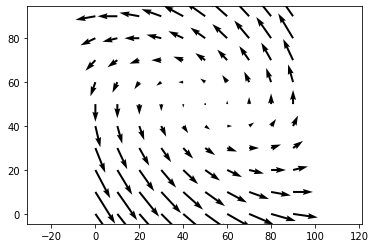

In [24]:
workingDbc = gl.DbGrid.create([10,10],[10,10])
spirale(workingDbc,plot=True);

In [26]:
resultDb = gl.DbGrid.create([200,200],[0.5,0.5]) 
x1 = resultDb['x1']
x2 = resultDb['x2']
theta = spirale(resultDb)
iatt = resultDb['theta'] = theta
resultDb.setLocator("theta",gl.ELoc.NOSTAT)
resultDb


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of fields             = 4
Maximum Number of attributes = 4
Total number of samples      = 40000

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      0.500     0.500
Number :        200       200

Variables
---------
Field = 1 - Name = rank - Locator = NA
Field = 2 - Name = x1 - Locator = x1
Field = 3 - Name = x2 - Locator = x2
Field = 4 - Name = theta - Locator = nostat1

In [27]:
np.random.seed(124)
ndat=10000
coords=np.random.uniform(1,99,size=(ndat,2))
dat = gl.Db()
dat["X"]= coords[:,0]
dat["Y"]= coords[:,1]
dat.setLocator(['X','Y'],gl.ELoc.X)

In [28]:
model = gl.Model.createFromDb(resultDb)
cova = gl.CovAniso(gl.ECov.BESSEL_K,model.getContext()) #Alias ECov.MATERN
cova.setRanges([4,45])
model.addCova(cova)

In [30]:
workingDb = gl.DbGrid.create([101,101],[1.,1.]) 
mesh = gl.MeshETurbo(workingDb)

In [31]:
NoStat = gl.NoStatArray(["A"], resultDb)
#err = model.addNoStat(NoStat)

In [32]:
S = gl.ShiftOpCs(mesh, model, resultDb)

In [33]:
Qsimu = gl.PrecisionOp(S, cova, gl.EPowerPT.MINUSHALF, False)

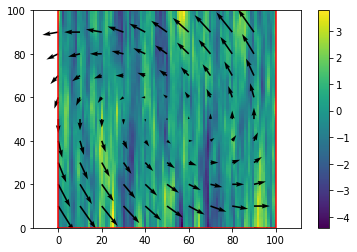

In [34]:
vect = gl.VectorDouble(np.random.normal(size=Qsimu.getSize()))
result = gl.VectorDouble(np.empty_like(vect))
Qsimu.eval(vect,result)
workingDb.addFields(result,"Simu",gl.ELoc.X)

gp.grid(workingDb,"Simu")
spirale(workingDbc,plot=True);

In [35]:
ind = np.random.choice(workingDb.getActiveSampleNumber(), size=100, replace=False)
data = gl.Db()
data['x1'] = workingDb['x1'][ind]
data['x2'] = workingDb['x1'][ind]
data['z']  = workingDb['Simu'][ind]
data.setLocator('x*',gl.ELoc.X)
data.setLocator('z',gl.ELoc.Z)
data


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of fields             = 3
Maximum Number of attributes = 3
Total number of samples      = 100

Variables
---------
Field = 1 - Name = x1 - Locator = x1
Field = 2 - Name = x2 - Locator = x2
Field = 3 - Name = z - Locator = z1

In [36]:
spde = gl.SPDE(model,resultDb,data,gl.ESPDECalcMode.SIMUNONCOND)


Grid characteristics:
---------------------
Origin :     -1.429   -16.071
Mesh   :      0.286     3.214
Number :        359        41
 
Turbo Meshing
-------------
Diamond construction is activated
Euclidean Geometry
Space Dimension           = 2
Number of Apices per Mesh = 3
Number of Meshes          = 28640
Number of Apices          = 14719

Bounding Box Extension
----------------------
Dim #1 - Min:-1.42857 - Max:100.857
Dim #2 - Min:-16.0714 - Max:112.5
 

In [37]:
spde.compute()

In [38]:
spde.query(workingDb)

4

<AxesSubplot:>

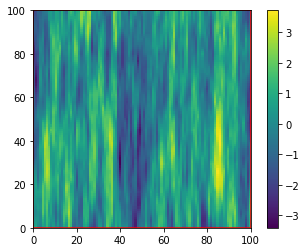

In [39]:
gp.grid(workingDb,'*simu')